In [1]:
import json, gzip

import numpy as np
import pandas as pd
from ete3 import Tree

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patheffects import withStroke
from matplotlib.transforms import offset_copy

from colaml.misc import dataplot, modelplot, phyplot
from colaml.__main__ import phytbl_from_json, model_from_json

from myconfig import DATA_DIR, DATASET_DIR, ROOT_DIR
from plotutil import *

In [2]:
%matplotlib inline

In [3]:
data_path = DATA_DIR/'inspect-real-data'/'fish'/'fish-lmax2-filt05.json.gz'
model_path = ROOT_DIR/'results'/'fish-lmax2-filt05.bestfit.json.gz'
mmm = model_from_json(model_path)

In [4]:
with gzip.open(ROOT_DIR/'results'/'fish-lmax2-filt05-mrglrecon.json.gz') as file:
    tmp = json.load(file)
    
tree = Tree(tmp['tree'], format=3)
reconcpy = pd.DataFrame(**tmp['recon'])
reconcat = pd.DataFrame(**tmp['otherstates'][0]['states'])

In [5]:
tree_rename_dict = {
    'i206': 'i206', 'i205': 'i205', 'i204': 'i204', 'i203': 'i203 [Teleostei]', 
    'i202': 'i202', 'i201': 'i201', 'i200': 'i200', 

    'i2'                          : 'i2'                              , # Polypteriformes
    'Erpetoichthys_calabaricus'   : '$\it{Erpetoichthys~calabaricus}$', 
    'Polypterus_senegalus'        : '$\it{Polypterus~senegalus}$'     , 
    'i5'                          : 'i5'                              ,
    'Acipenser_ruthenus'          : '$\it{Acipenser~ruthenus}$'       , 
    'Polyodon_spathula'           : '$\it{Polyodon~spathula}$'        ,    

    'i50'                         : 'i50'                             , # Cyprinidae
    'Danio_rerio'                 : '$\it{Danio~rerio}$'              ,
    'Puntigrus_tetrazona'         : '$\it{Puntigrus~tetrazona}$'      ,
    'i47'                         : 'i47'                             , # Cyprininae
    'Carassius_auratus'           : '$\it{Carassius~auratus}$'        ,
    'Cyprinus_carpio'             : '$\it{Cyprinus~carpio}$'          ,
    'i46'                         : 'i46 [Sinocyclocheilus]'          , 

    'i74'                         : 'i74'                             , # Protacanthopterygii
    'Esox_lucius'                 : '$\it{Esox~lucius}$'              , 
    'i73'                         : 'i73'                             , # Salmonidae
    'i70'                         : 'i70 [Oncorhynchus]'              , # Oncorhynchus
    'i61'                         : 'i61 [Salmo]'                     , # Salmo
    'i58'                         : 'i58 [Salvelinus]'                , # Salvelinus

    'i199'                        : ' $\downarrow$  (63) [Stomiati / Neoteleostei]', 
    'i9'                          : '(2)', # Elopomorpha
    'i12'                         : '(2)', # Osteoglossiformes
    'i19'                         : '(4)', 
    'i35'                         : '(8)', 
    'i39'                         : '(2)', 
    'Chanos_chanos'               : '(1)', 
    'Lepisosteus_oculatus'        : '(1)', 
    'Coregonus_clupeaformis'      : '(1)', 
}

    
def plot_tree(ax):
    # format tree
    tmp_tree = tree.copy()
    _, height = tmp_tree.get_farthest_leaf()

    for ndname in ('i9', 'i12', 'i19', 'i35', 'i39'):
        nd = tmp_tree & ndname
        nd.dist += np.mean([*map(nd.get_distance, nd.iter_leaves())])

    (tmp_tree & 'i199').dist = 0
    [nd.detach() 
     for rt in ('i199', 'i9', 'i12', 'i19', 'i35', 'i39')
     for nd in (tmp_tree & rt).get_children()]

    # draw tree
    phyplot.draw(
        tmp_tree, horizontal=True, 
        show_confidence=False, 
        node_text=lambda nd: tree_rename_dict.get(nd.name), 
        cladelc={
            tmp_tree: 'lightgray'
        } | {
            tmp_tree & ndname: 'crimson'
            for ndname in ('i5', 'i47', 'i73')
        } | {
            tmp_tree & ndname: 'pink'
            for ndname in ('i2', 'i50', 'i74')
        },
        nodelc={
            tmp_tree & ndname: 'k'
            for ndname in ('i205', 'i204', 'i203', 'i202', 'i201', 'i200')
        } | {
            tmp_tree & ndname: 'lightgray'
            for ndname in ('i50', 'i74')
        }, 
        cladelw={
            tmp_tree: lw * 0.75
        } | {
            tmp_tree & ndname: lw
            for ndname in ('i5', 'i47', 'i73', 'i2', 'i50', 'i74')
        },
        nodelw={
            tmp_tree & ndname: lw
            for ndname in ('i205', 'i204', 'i203', 'i202', 'i201', 'i200')
        } | {
            tmp_tree & ndname: lw * 0.75
            for ndname in ('i50', 'i74')
        }, 
        branch_text={
            tmp_tree & 'i5'                : '3R?', 
            tmp_tree & 'Acipenser_ruthenus': '3R?', 
            tmp_tree & 'Polyodon_spathula' : '3R?',
            tmp_tree & 'i203'              : '3R', 
            tmp_tree & 'i47'               : '4R', 
            tmp_tree & 'i73'               : '4R', 
        }.get, 
        branch_textkw=dict(
            fontsize='x-small', ha='center', va='center', 
            path_effects=[withStroke(linewidth=2, foreground='w')]
        ),
        node_textkw=dict(
            fontsize='xx-small', rotation=0, ha='left', va='center', rotation_mode='anchor',  
            path_effects=[withStroke(linewidth=2, foreground='w')]
        ), 
        local_branch_textkw={
            tmp_tree & 'Acipenser_ruthenus': dict(fontsize='xx-small', va='baseline'), 
            tmp_tree & 'Polyodon_spathula' : dict(fontsize='xx-small', va='top'), 
        }, 
        local_node_textkw={
            tmp_tree & ndname: dict(c='gray')
            for ndname in ['i199', 'i9', 'i12', 'i19', 'i35', 'i39', 
                           'Chanos_chanos', 'Lepisosteus_oculatus', 'Coregonus_clupeaformis']
        },
        ax=ax
    )
    
    return ax

In [6]:
bar_rename_dict = {
    'Erpetoichthys_calabaricus'   : 'Ec' , 
    'Polypterus_senegalus'        : 'Pse', 
    'Acipenser_ruthenus'          : 'Ar' , 
    'Polyodon_spathula'           : 'Psp', 
    'Danio_rerio'                 : 'Dr' , 
    'Puntigrus_tetrazona'         : 'Pt' , 
    'Carassius_auratus'           : 'Ca' ,
    'Cyprinus_carpio'             : 'Cc' ,
    'Sinocyclocheilus_grahami'    : 'Sg' ,
    'Sinocyclocheilus_rhinocerous': 'Sr' , 
    'Esox_lucius'                 : 'El' , 
}

cat_counts = (
    reconcat
    .mask(reconcpy.eq(0))
    .rename(bar_rename_dict)
    .apply(lambda s: s.value_counts(), axis=1)
    .reindex(columns=[0,1,2])
)

clades = [
    ('Teteostei 3R', ['i206', 'i205', 'i204'], ['i203', 'i202', 'i201', 'i200']),  
    ('Acipenser/Polyodon 3R', ['i2', 'Ec', 'Pse'], ['i5', 'Ar', 'Psp']),
    ('Cyprininae 4R', ['i50', 'Dr', 'Pt'], ['i47', 'i46', 'Ca', 'Cc']), 
    ('Salmonidae 4R', ['i74', 'El'], ['i73', 'i70', 'i61', 'i58'])
]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


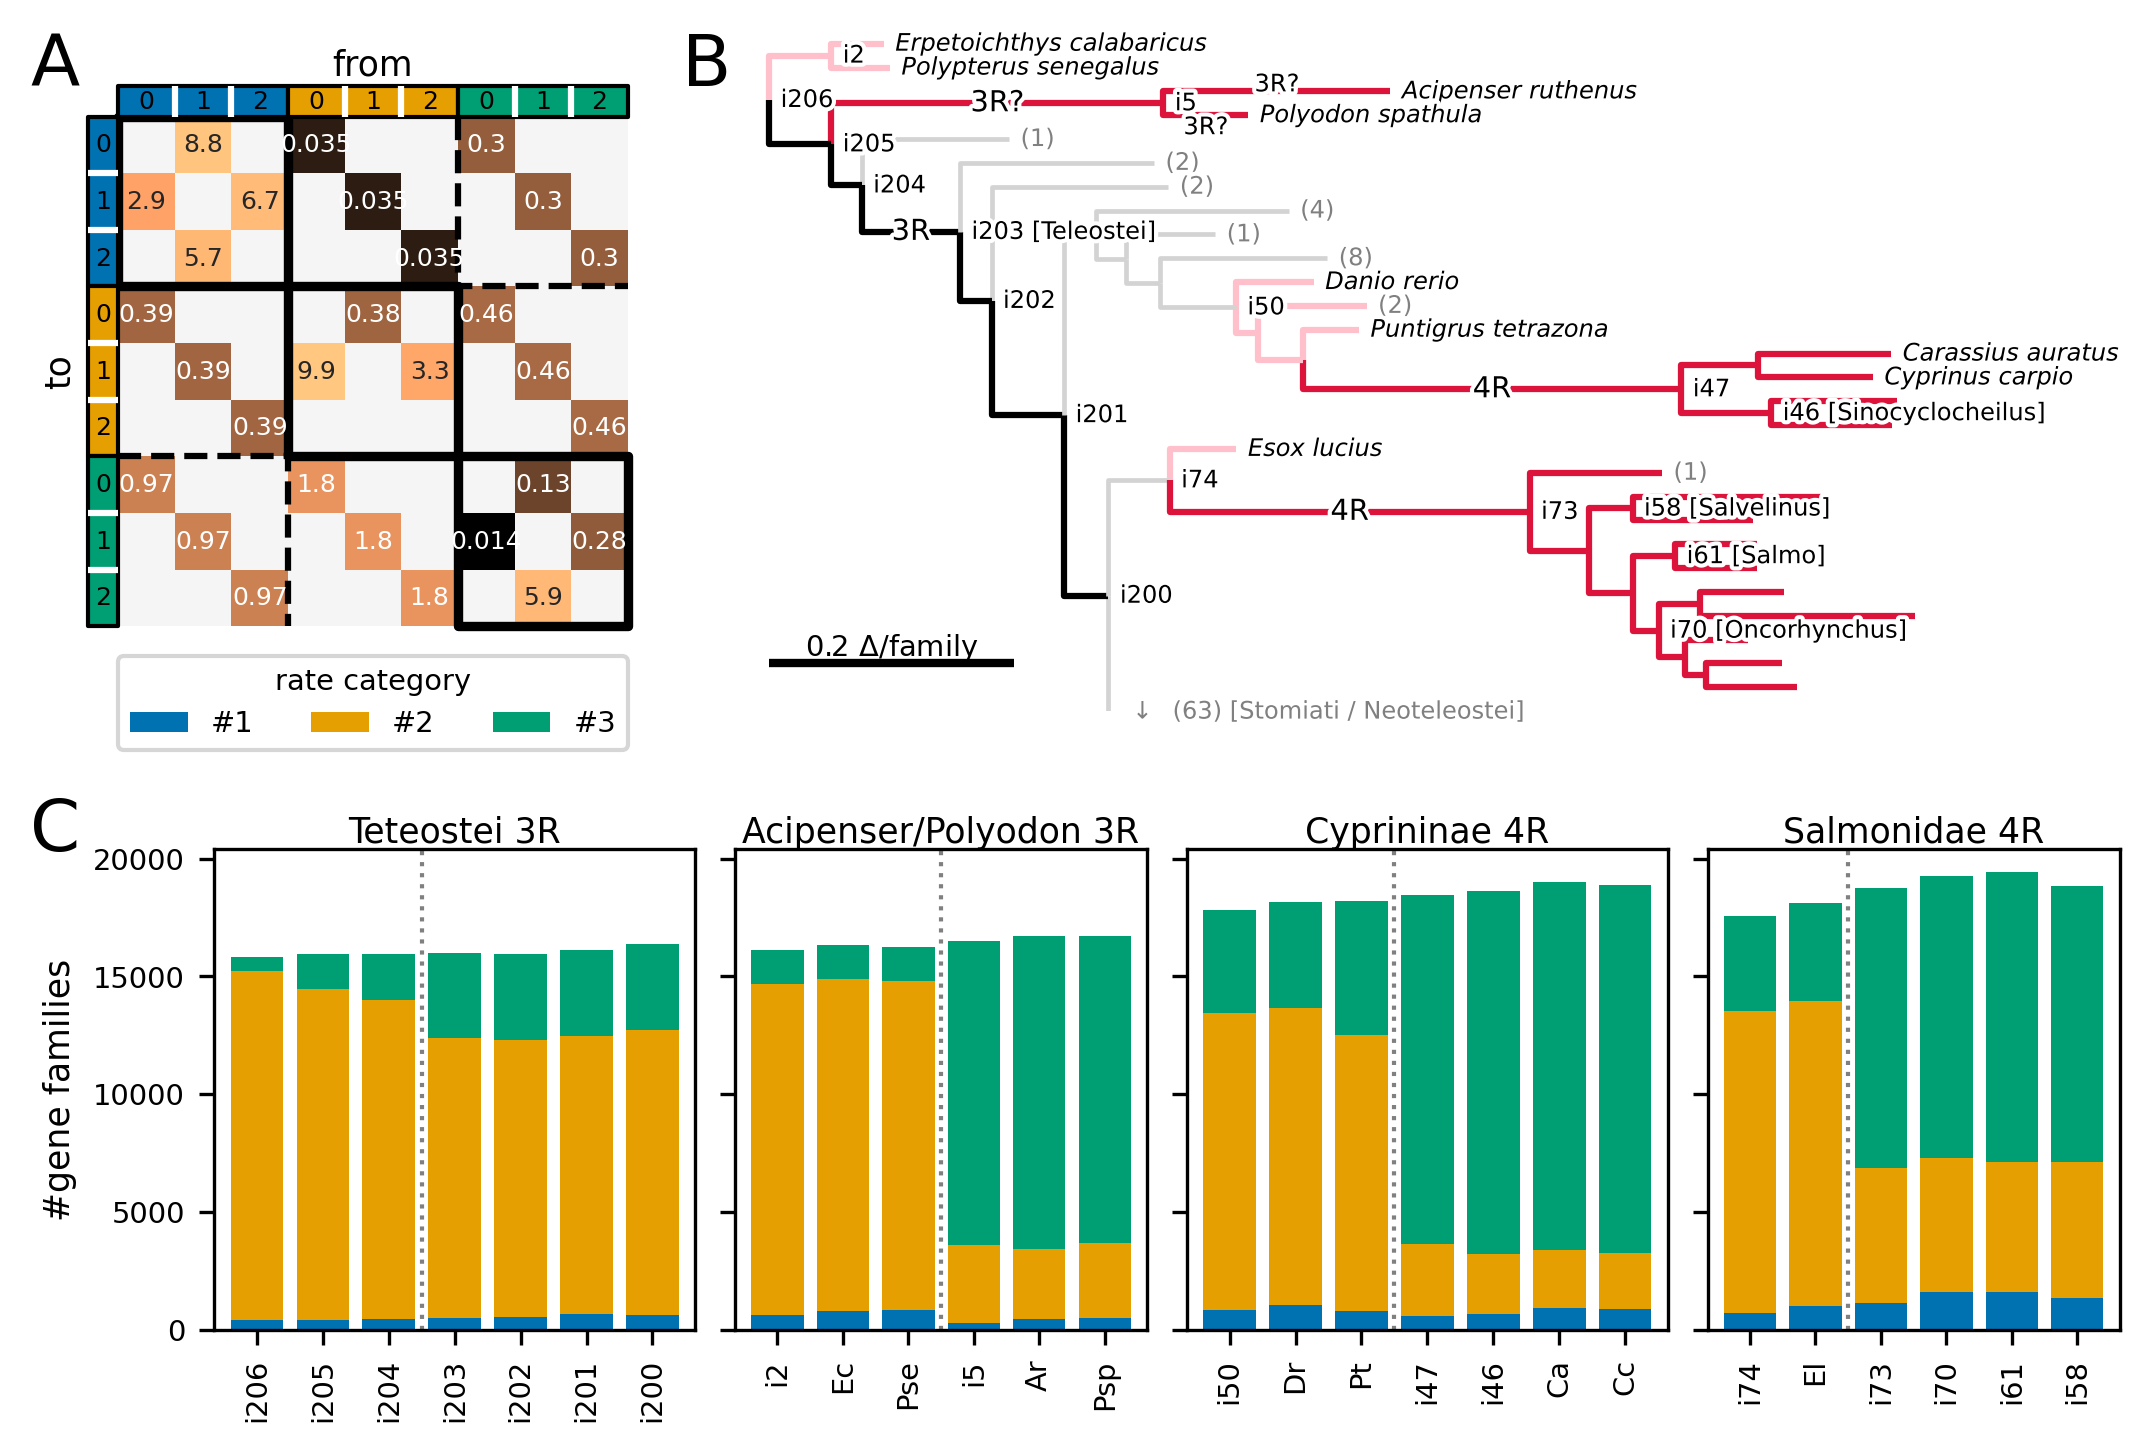

In [7]:
with plt.rc_context({'axes.prop_cycle': OkabeItoCUDcy}):
    fig, axd = plt.subplot_mosaic(
        'AB\nCC', 
        gridspec_kw=dict(hspace=0.15, height_ratios=[6,5], wspace=0.04, width_ratios=[4,11]), 
        layout='constrained', figsize=(178*mm, 120*mm), dpi=300
    )
    
    lw = plt.rcParams['lines.linewidth']
    ax = plot_tree(axd['B'])
    ax.set_frame_on(False)
    ax.hlines(26, 0, 0.2, lw=2, color='k')
    ax.text(0.1, 26, '0.2 $\Delta$/family', ha='center', va='bottom', fontsize='x-small')
    ax.set_xbound(upper=1.1)
    ax.set_ybound(upper=28)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

    axesC = (
        axd['C']
        .get_subplotspec()
        .subgridspec(1, 4, wspace=0, width_ratios=[len(pre)+len(post) for _, pre, post in clades])
        .subplots(sharey=True)
    ) # wspace is not working due to constrained layout
    axd['C'].set_frame_on(False)
    axd['C'].tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)

    for (label, pre, post), ax in zip(clades, axesC):
        cat_counts.loc[pre + post].plot.bar(stacked=True, width=0.8, legend=False, ax=ax)
        ax.axvline(len(pre)-0.5, c='gray', lw=1, ls=':')
        ax.set_title(label, fontsize='small', pad=0)
        ax.tick_params(labelsize='x-small')

    axesC[0].set_ylabel('#gene families', size='small')

    # Somehow "from" disappers when panel A is drown before C
    ax = axd['A']
    ax.set_aspect('equal')
    with plt.rc_context({'font.size': 6}):
        modelplot.plot_substmodel(mmm.substmodel, ax=ax)
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('left')
    ax.set_xlabel('from', labelpad=10, fontsize='small', visible=True)
    ax.set_ylabel('to'  , labelpad=10, fontsize='small', visible=True)
    ax.legend(
        [plt.Rectangle((0,0),0,0,fc=fc) for fc in ('C0','C1','C2')], 
        ['#1','#2','#3'], 
        loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.03), fontsize='x-small', 
        title='rate category', title_fontsize='x-small'
    )
    
    for label in [(0, 0.99, 'A'), (0.31, 0.99, 'B'), (0, 0.45, 'C')]:
        fig.text(*label, size='xx-large', ha='left', va='top')

    fig.canvas.draw()
    
    #fig.savefig('jpg/usecase-fish.jpg', bbox_inches='tight', dpi=350)
    #fig.savefig('png/usecase-fish.png', bbox_inches='tight', dpi=350)
    #fig.savefig('pdf/usecase-fish.pdf', bbox_inches='tight')
    fig.savefig('eps/usecase-fish.eps', bbox_inches='tight')